# Requirements

In [ ]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle
!pip install datasets

# Libraries

In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datasets import Dataset


# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# Torch Libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# System Libraries
from pathlib import Path
import os
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2
from transformers import ViTFeatureExtractor, ViTForImageClassification, Trainer, TrainingArguments

# Extra
import zipfile
from termcolor import colored
#from google.colab import drive
import cv2
from skimage.feature import canny
from collections import defaultdict, Counter

# Data

## Directory

In [ ]:
PATH = '/kaggle/input/deepfakesss/similar'
PATH_styletransfer = '/kaggle/input/deepfakesss/similar/style_transfer'
PATH_inpainting = '/kaggle/input/deepfakesss/similar/inpainting'
PATH_old = '/kaggle/input/dataset'
images = []
class_list = []
labels_class = ['Original', 'AI Generated']
labels_class

['Original', 'AI Generated']

## Creating Dataframe

In [ ]:
folder_path = PATH_inpainting
max_images_per_class = 20

# Initialize list and counters
image_data = []
class_0_count = 0
class_1_count = 0

# Iterate through class folders
for class_name in os.listdir(folder_path):
    class_path = os.path.join(folder_path, class_name)
    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        # Stop if both class limits are reached
        if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
            break

        file_path = os.path.join(class_path, file)

        # Append file paths and labels
        if file == 'original.png' and class_0_count < max_images_per_class:
            image_data.append((file_path, 0))
            class_0_count += 1
        elif file == 'inpainting.png' and class_1_count < max_images_per_class:
            image_data.append((file_path, 1))
            class_1_count += 1

# Create DataFrame from collected data
dataset = pd.DataFrame(image_data, columns=['file_path', 'label'])

# Display the DataFrame
dataset

,file_path,label
0,/kaggle/input/deepfakesss/similar/inpainting/1...,0
1,/kaggle/input/deepfakesss/similar/inpainting/1...,1
2,/kaggle/input/deepfakesss/similar/inpainting/2...,0
3,/kaggle/input/deepfakesss/similar/inpainting/2...,1
4,/kaggle/input/deepfakesss/similar/inpainting/4...,0
5,/kaggle/input/deepfakesss/similar/inpainting/4...,1
6,/kaggle/input/deepfakesss/similar/inpainting/1...,0
7,/kaggle/input/deepfakesss/similar/inpainting/1...,1
8,/kaggle/input/deepfakesss/similar/inpainting/1...,0
9,/kaggle/input/deepfakesss/similar/inpainting/1...,1


In [ ]:
class_0_count = 0
class_1_count = 0
max_images_per_class = 10
new_data = []  # List to store new data for appending

# Iterate through each class in the style_transfer folder
for class_name in os.listdir(PATH_styletransfer):
    class_path = os.path.join(PATH_styletransfer, class_name)

    if not os.path.isdir(class_path):
        continue

    for file in os.listdir(class_path):
        if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
            break

        file_path = os.path.join(class_path, file)

        # Append file paths and labels to new_data
        if file.endswith("original.png") and class_0_count < max_images_per_class:
            new_data.append((file_path, 0))
            class_0_count += 1
        elif file.endswith("generated.png") and class_1_count < max_images_per_class:
            new_data.append((file_path, 1))
            class_1_count += 1

    # Reset counts for the next class
    class_0_count = 0
    class_1_count = 0

# Convert new_data to a DataFrame
new_df = pd.DataFrame(new_data, columns=['file_path', 'label'])

# Append to the existing DataFrame
if 'dataset' in locals():
    dataset = pd.concat([dataset, new_df], ignore_index=True)
else:
    dataset = new_df

dataset

,file_path,label
0,/kaggle/input/deepfakesss/similar/inpainting/1...,0
1,/kaggle/input/deepfakesss/similar/inpainting/1...,1
2,/kaggle/input/deepfakesss/similar/inpainting/2...,0
3,/kaggle/input/deepfakesss/similar/inpainting/2...,1
4,/kaggle/input/deepfakesss/similar/inpainting/4...,0
...,...,...
575,/kaggle/input/deepfakesss/similar/style_transf...,1
576,/kaggle/input/deepfakesss/similar/style_transf...,0
577,/kaggle/input/deepfakesss/similar/style_transf...,0
578,/kaggle/input/deepfakesss/similar/style_transf...,0


In [ ]:
max_images_per_class = 20

all_images = []

# Iterate through all subdirectories in the folder
for class_name in os.listdir(PATH_old):
    class_path = os.path.join(PATH_old, class_name)

    if os.path.isdir(class_path):
        # Assign label 1 if "AI" is in the folder name, otherwise 0
        label = 1 if "AI" in class_name else 0

        # Collect file paths and labels
        class_images = [(os.path.join(class_path, file_name), label) for file_name in os.listdir(class_path)]

        # Limit the number of images per class
        all_images.extend(class_images[:max_images_per_class])

# Convert the collected data into a DataFrame
new_df = pd.DataFrame(all_images, columns=['file_path', 'label'])

# Combine with the existing dataset if it exists
if 'dataset' in locals() and isinstance(dataset, pd.DataFrame):
    dataset = pd.concat([dataset, new_df], ignore_index=True)
else:
    dataset = new_df

# Display the combined DataFrame
dataset

,file_path,label
0,/kaggle/input/deepfakesss/similar/inpainting/1...,0
1,/kaggle/input/deepfakesss/similar/inpainting/1...,1
2,/kaggle/input/deepfakesss/similar/inpainting/2...,0
3,/kaggle/input/deepfakesss/similar/inpainting/2...,1
4,/kaggle/input/deepfakesss/similar/inpainting/4...,0
...,...,...
935,/kaggle/input/dataset/realism/theodor-severin-...,0
936,/kaggle/input/dataset/realism/ippolito-caffi_r...,0
937,/kaggle/input/dataset/realism/alexey-venetsian...,0
938,/kaggle/input/dataset/realism/rosa-bonheur_thr...,0


# Exploratory Data Analysis

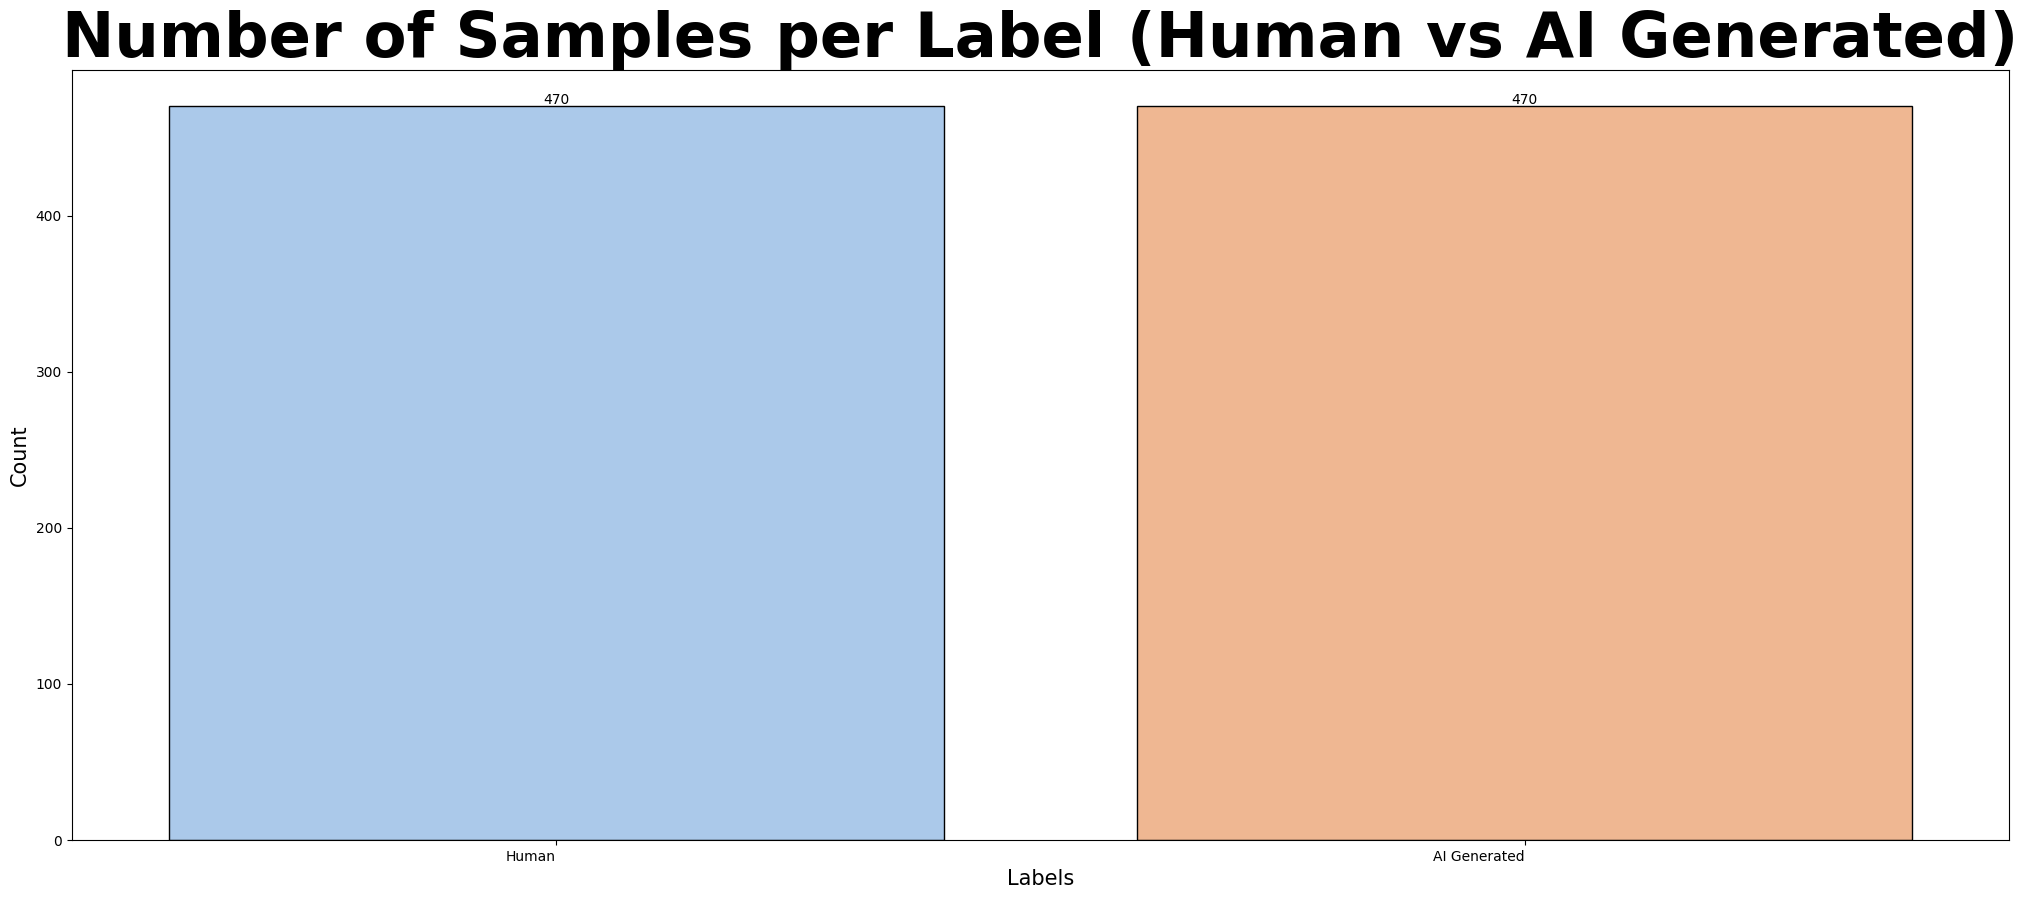

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples per label
label_counts = dataset['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Map the labels (0 to 'Human', 1 to 'AI Generated')
label_counts['label'] = label_counts['label'].map({0: 'Human', 1: 'AI Generated'})

# Plotting
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=label_counts, x='label', y='count', edgecolor='black', palette='pastel')

# Adding labels to the bars
for i in ax.containers:
    ax.bar_label(i)

# Set plot title and labels
plt.title('Number of Samples per Label (Human vs AI Generated)', fontsize=45, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ha='right')
plt.show()


# Data Preprocessing

## Resize Image

In [ ]:
def preprocess_image(image_path, size=(224, 224)):
    # Load the image from the file path
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")

    # Resize the image to the given size
    image_resized = cv2.resize(image, size)

    return image_resized

## Feature Detector

In [ ]:
!pip install --upgrade scikit-image

In [ ]:
import cv2
import numpy as np
from skimage import feature
from scipy.fftpack import dct

# Helper function for DCT-based Color Layout
def compute_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Color Layout Descriptor (CLD) using DCT
def extract_color_layout(image):
    # Resize to 8x8 for compact representation
    image_resized = cv2.resize(image, (8, 8))
    # Convert to YCrCb color space
    image_ycc = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCrCb)

    # Split the Y, Cr, and Cb channels
    y, cr, cb = cv2.split(image_ycc)

    # Compute DCT coefficients on each channel
    y_dct = compute_dct(y)
    cr_dct = compute_dct(cr)
    cb_dct = compute_dct(cb)

    features = np.hstack([y_dct[:6, :6].flatten(), cr_dct[:6, :6].flatten(), cb_dct[:6, :6].flatten()])
    return features

# Color Structure Descriptor (CSD) using structured histogram
def extract_color_structure(image):
    # Convert to HSV color space for color information
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Use a structuring element (e.g., 3x3) to capture spatial layout of colors
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    image_morphed = cv2.morphologyEx(image_hsv, cv2.MORPH_CLOSE, struct_elem)

    # Calculate histogram with structure in mind
    hist = cv2.calcHist([image_morphed], [0, 1], None, [8, 8], [0, 180, 0, 256])
    cv2.normalize(hist, hist)

    return hist.flatten()

# Edge Histogram Descriptor (EHD) using directional edges
def extract_edge_histogram(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect edges using Canny
    edges = cv2.Canny(gray, 100, 200)

    # Compute directionality of edges
    angles = feature.hog(edges, orientations=5, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

    return angles

# Homogeneous Texture Descriptor (HTD) using LBP and GLCM
def extract_homogeneous_texture(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute Local Binary Patterns (LBP) as texture measure
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')

    # Histogram of LBP values (normalized)
    (hist_lbp, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= hist_lbp.sum()

    # Use GLCM (Gray-Level Co-occurrence Matrix) for second-order texture
    glcm = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = feature.graycoprops(glcm, 'contrast').flatten()
    homogeneity = feature.graycoprops(glcm, 'homogeneity').flatten()

    # Combine LBP and GLCM features
    texture_features = np.hstack([hist_lbp, contrast, homogeneity])

    return texture_features

# Main function to extract MPEG-7-like features
def extract_mpeg7_features(image_path):
    image = cv2.imread(image_path)

    color_layout = extract_color_layout(image)
    color_structure = extract_color_structure(image)
    edge_histogram = extract_edge_histogram(image)
    homogeneous_texture = extract_homogeneous_texture(image)

    # Combine all features into a single feature vector
    features = np.hstack([color_layout, color_structure, edge_histogram, homogeneous_texture])

    return features

## Execution

#### Resize

In [ ]:
dataset['preprocessed_image'] = dataset['file_path'].apply(preprocess_image)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


#### Extract Features

In [ ]:
dataset['features'] = dataset['file_path'].apply(extract_mpeg7_features)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [ ]:
def pad_features(features, max_length):
    padded = np.zeros(max_length)
    padded[:len(features)] = features
    return padded

# Find the maximum feature vector length
max_length = max([len(f) for f in dataset['features']])

# Pad features to ensure consistent length
dataset['padded_features'] = dataset['features'].apply(lambda f: pad_features(f, max_length))

In [ ]:
# import random

# # Function to visualize extracted features from a random image in the dataset
# def visualize_random_image_features(dataset):
#     # Randomly select a row from the dataset
#     random_row = dataset.sample(1).iloc[0]

#     # Retrieve the image path and the extracted features
#     image_path = random_row['file_path']
#     features = random_row['features']

#     # Preprocess the image (just for visualization)
#     image = preprocess_image(image_path)

#     # Visualize pyramid features
#     # Assuming the pyramid features were concatenated, split them back into levels
#     pyramid_levels = [image.shape[0] * image.shape[1],  # Original size
#                       (image.shape[0] // 2) * (image.shape[1] // 2),  # Level 1
#                       (image.shape[0] // 4) * (image.shape[1] // 4),  # Level 2
#                       (image.shape[0] // 8) * (image.shape[1] // 8)]  # Level 3

#     pyramid_feat = np.split(features[:sum(pyramid_levels)], np.cumsum(pyramid_levels)[:-1])
#     fig, axes = plt.subplots(1, len(pyramid_feat), figsize=(12, 4))
#     for i, p in enumerate(pyramid_feat):
#         axes[i].imshow(p.reshape((image.shape[0] // (2 ** i), image.shape[1] // (2 ** i))), cmap='gray')
#         axes[i].set_title(f"Pyramid Level {i}")
#         axes[i].axis('off')
#     plt.show()

#     # Visualize edge features
#     edge_feat = features[sum(pyramid_levels):sum(pyramid_levels) + (image.shape[0] * image.shape[1])]
#     plt.figure(figsize=(6, 6))
#     plt.imshow(edge_feat.reshape(image.shape[:2]), cmap='gray')
#     plt.title("Edge Features")
#     plt.axis('off')
#     plt.show()

#     # Visualize HSV histogram
#     hsv_hist = features[sum(pyramid_levels) + (image.shape[0] * image.shape[1]):]
#     hsv_hist = hsv_hist.flatten()

#     # Plot the histogram for each channel (Hue, Saturation, Value)
#     fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#     ax[0].plot(hsv_hist[:8], color='r')
#     ax[0].set_title('Hue Histogram')
#     ax[1].plot(hsv_hist[8:16], color='g')
#     ax[1].set_title('Saturation Histogram')
#     ax[2].plot(hsv_hist[16:], color='b')
#     ax[2].set_title('Value Histogram')
#     plt.show()

# # Example usage:
# # Assuming `dataset` is a DataFrame with 'file_path' and 'features' columns
# visualize_random_image_features(dataset)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming your dataset has a 'target' column
label_encoder = LabelEncoder()
dataset['label_encoded'] = label_encoder.fit_transform(dataset['label'])

# Splitting the dataset into features (X) and the target (y)
X = np.vstack(dataset['padded_features'].values)
y = dataset['label_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 87.23%


<Figure size 1600x600 with 0 Axes>

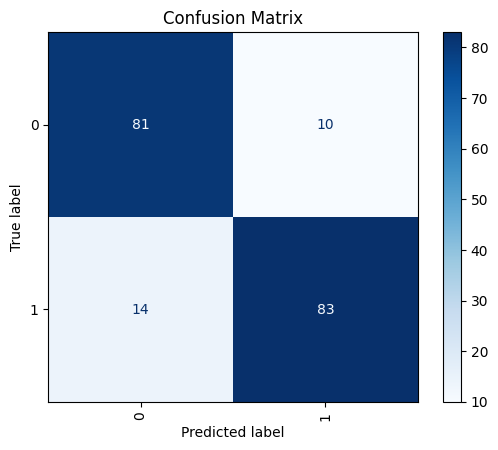

Accuracy: 87.23%


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')

# Rotate x-axis labels
plt.xticks(rotation=90)

plt.title('Confusion Matrix')
plt.show()

# Optional: Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
import pickle
# Save the model using pickle
with open("xgb_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)
print("Model saved with pickle as 'xgb_model.pkl'")

# Save the model in JSON format
xgb_model.save_model("xgb_model.json")
print("Model saved in JSON format as 'xgb_model.json'")

Model saved with pickle as 'xgb_model.pkl'
Model saved in JSON format as 'xgb_model.json'


# AdaBoost

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 83.51%


<Figure size 800x600 with 0 Axes>

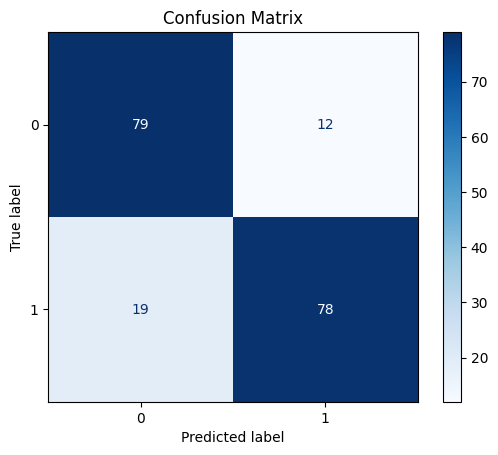

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the J48 equivalent decision tree
j48_tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1)

# Create the AdaBoost classifier using the J48 decision tree
adaboost_model = AdaBoostClassifier(base_estimator=j48_tree, n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred = adaboost_model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle
from joblib import dump, load

# Save the AdaBoost model using pickle
pickle_file = "adaboost_model.pkl"
with open(pickle_file, "wb") as file:
    pickle.dump(adaboost_model, file)
print(f"Model saved with pickle as '{pickle_file}'")

# Save the AdaBoost model using joblib
joblib_file = "adaboost_model.joblib"
dump(adaboost_model, joblib_file)
print(f"Model saved with joblib as '{joblib_file}'")

Model saved with pickle as 'adaboost_model.pkl'
Model saved with joblib as 'adaboost_model.joblib'


# Random Forest

Accuracy: 74.47%


<Figure size 800x600 with 0 Axes>

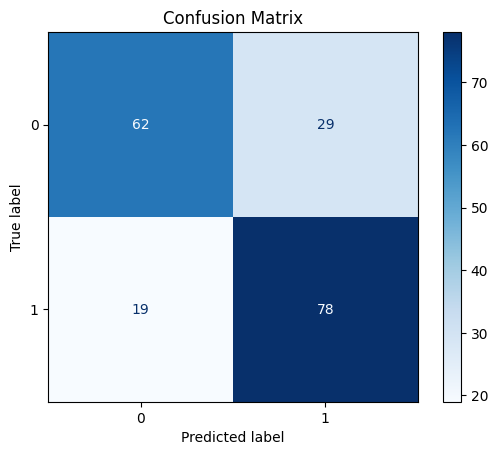

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Initialize the RandomForest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

# Train the RandomForest model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Save the RandomForest model using pickle
pickle_file = "random_forest_model.pkl"
with open(pickle_file, "wb") as file:
    pickle.dump(random_forest_model, file)
print(f"Model saved with pickle as '{pickle_file}'")

# Save the RandomForest model using joblib
joblib_file = "random_forest_model.joblib"
dump(random_forest_model, joblib_file)
print(f"Model saved with joblib as '{joblib_file}'")

Model saved with pickle as 'random_forest_model.pkl'
Model saved with joblib as 'random_forest_model.joblib'
